In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
!pip install pyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 1.9 MB/s eta 0:00:00a 0:00:01m


In [2]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Lambda, SeparableConv2D, GlobalAvgPool2D, Input, Average, ReLU, Dropout, DepthwiseConv2D, Dense, GlobalAvgPool2D, GlobalAveragePooling2D,Conv2D, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, AvgPool2D, Concatenate, MaxPool2D
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU


from keras.preprocessing import image

from glob import glob

from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential,Model
import pandas as pd
# from keras.applications.resnet import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import time
import datetime
import os
import cv2
import io

# import imutils
import matplotlib.pyplot as plt
from os import listdir

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

2024-03-05 05:11:09.696611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 05:11:09.696668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 05:11:09.698155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set the path to the dataset
# dataset_path = "C:/Users/USER/ML/Latest/def_data"
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Training")
test_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

1321
1339
1595
1457


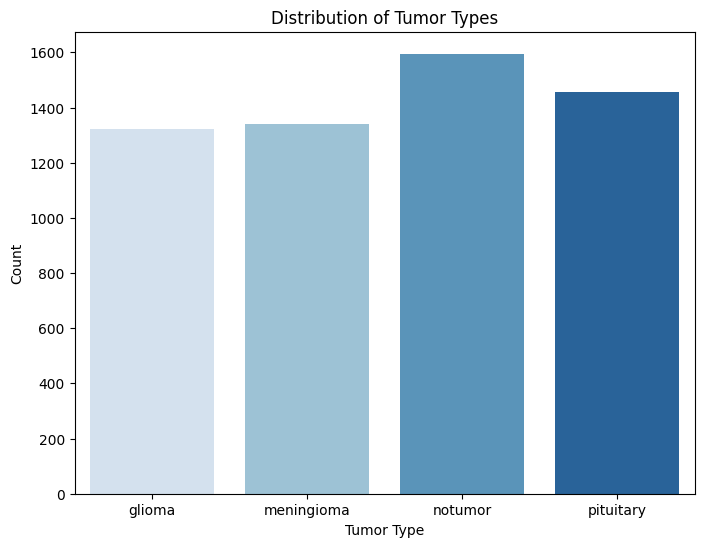

In [5]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count", palette = "Blues")#######, legend=False
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

300
306
405
300


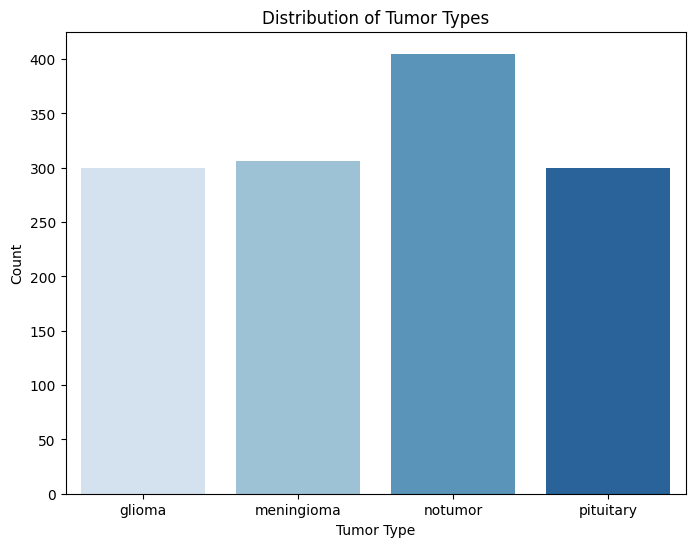

In [6]:
# Load and preprocess the dataset
test_data = []
for category in categories:
    folder_path = os.path.join(test_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    test_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

test_df = pd.concat(test_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=test_df, x="Category", y="Count", palette = "Blues")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

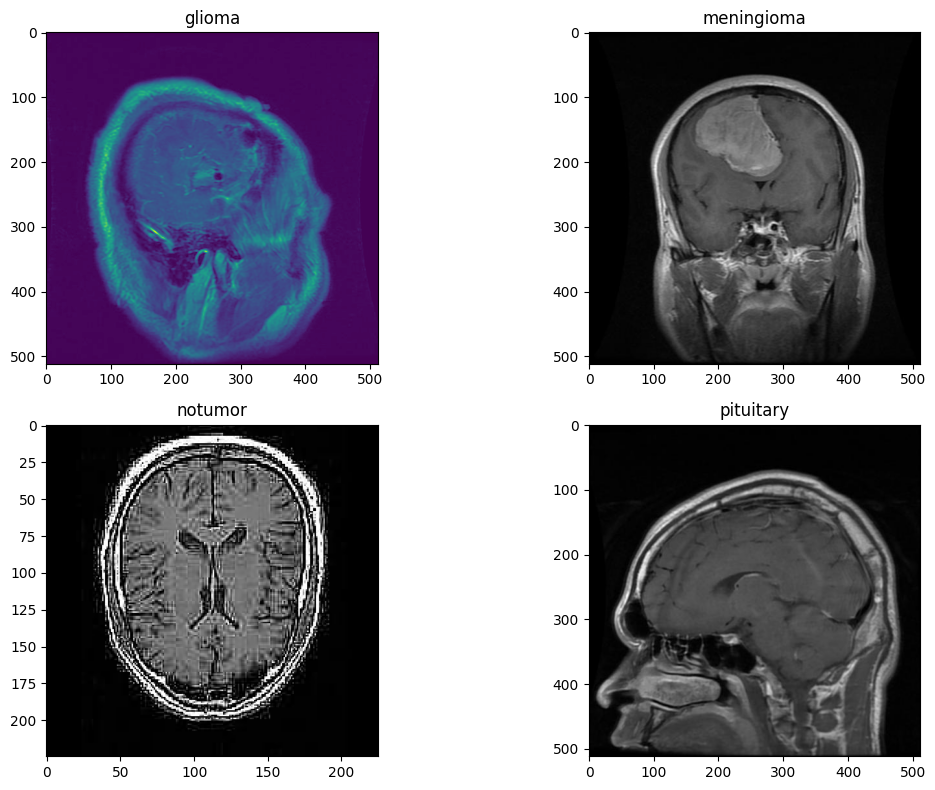

In [7]:
# Visualize sample images for each tumor type
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("on")
plt.tight_layout()
plt.show()

In [11]:
# Set the image size
image_size = (224, 224)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [9]:
# Data augmentation and preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [10]:
MobileNetV2 = keras.applications.MobileNetV2(input_shape=(224, 224, 3),
            weights='imagenet',
            include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
for layer in MobileNetV2.layers:
    layer.trainable = False

In [12]:
folders = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
print(len(folders))

4


In [13]:
x = MobileNetV2.output

x = Conv2D(256, 7, strides=2, padding='same', activation='relu')(x)
x = Dropout(0.6)(x)
x = Conv2D(512, 7, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(3, strides=2, padding='same')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
MobileNetV2_model = Model(inputs=MobileNetV2.input, outputs=prediction)

In [14]:
MobileNetV2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [13]:
from keras.applications.inception_v3 import InceptionV3
InceptionV3 = InceptionV3(input_shape=(224, 224, 3),
            weights='imagenet',
            include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [14]:
for layer in InceptionV3.layers:
    layer.trainable = False

In [15]:
folders = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
print(len(folders))

4


In [16]:
x = InceptionV3.output

x = Conv2D(256, 5, strides=2, padding='same', activation='relu')(x)
x = Conv2D(512, 5, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)


x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
prediction = Dense(len(folders), activation='softmax')(x)
InceptionV3_model = Model(inputs=InceptionV3.input, outputs=prediction)

In [17]:
InceptionV3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [20]:
# MobileNetV2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
adam = keras.optimizers.Adam(learning_rate=0.0001)
MobileNetV2_model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
InceptionV3_model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Train the model
history_MobileNetV2_model = MobileNetV2_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size
)

Epoch 1/50


2024-03-04 17:56:57.507962: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1709575021.181951     136 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 [==============================] - 106s 549ms/step - loss: 0.7359 - accuracy: 0.7225 - val_loss: 0.7214 - val_accuracy: 0.7859
Epoch 2/50
178/178 [==============================] - 68s 380ms/step - loss: 0.4584 - accuracy: 0.8324 - val_loss: 0.4786 - val_accuracy: 0.8297
Epoch 3/50
178/178 [==============================] - 69s 389ms/step - loss: 0.3790 - accuracy: 0.8570 - val_loss: 0.3871 - val_accuracy: 0.8664
Epoch 4/50
178/178 [==============================] - 68s 381ms/step - loss: 0.3502 - accuracy: 0.8687 - val_loss: 0.4258 - val_accuracy: 0.8430
Epoch 5/50
178/178 [==============================] - 69s 386ms/step - loss: 0.3271 - accuracy: 0.8755 - val_loss: 0.4583 - val_accuracy: 0.8375
Epoch 6/50
178/178 [==============================] - 67s 376ms/step - loss: 0.3031 - accuracy: 0.8923 - val_loss: 0.2997 - val_accuracy: 0.8805
Epoch 7/50
178/178 [==============================] - 68s 380ms/step - loss: 0.2867 - accuracy: 0.8988 - val_loss: 0.4186 - val_accuracy: 0.

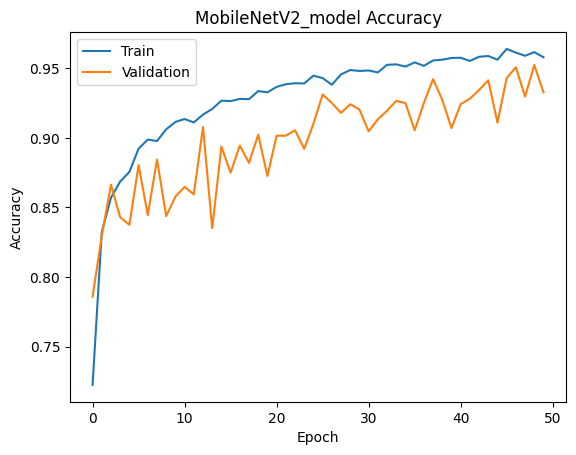

In [23]:
# Plot the training and validation accuracy over epochs
plt.plot(history_MobileNetV2_model.history['accuracy'])
plt.plot(history_MobileNetV2_model.history['val_accuracy'])
plt.title('MobileNetV2_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

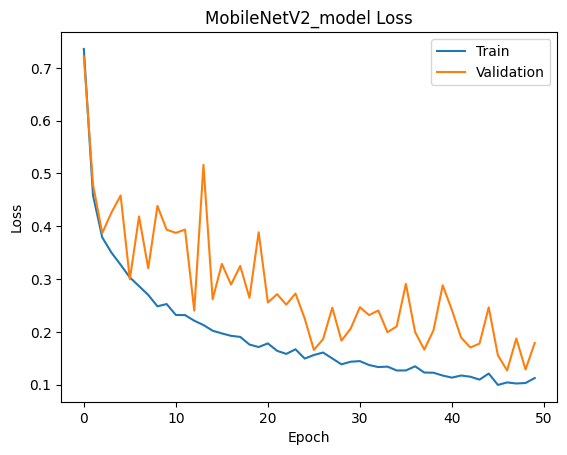

In [24]:
# Plot the training and validation loss over epochs
plt.plot(history_MobileNetV2_model.history['loss'])
plt.plot(history_MobileNetV2_model.history['val_loss'])
plt.title('MobileNetV2_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [25]:
# Evaluate the model
loss_MobileNetV2_model, accuracy_MobileNetV2_model = MobileNetV2_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("MobileNetV2_model Test Loss:", loss_MobileNetV2_model)
print("MobileNetV2_model Test Accuracy:", accuracy_MobileNetV2_model)

40/40 [==============================] - 3s 81ms/step - loss: 0.1790 - accuracy: 0.9328
MobileNetV2_model Test Loss: 0.1789996176958084
MobileNetV2_model Test Accuracy: 0.932812511920929


41/41 [==============================] - 6s 129ms/step
[0 0 0 ... 3 3 3]


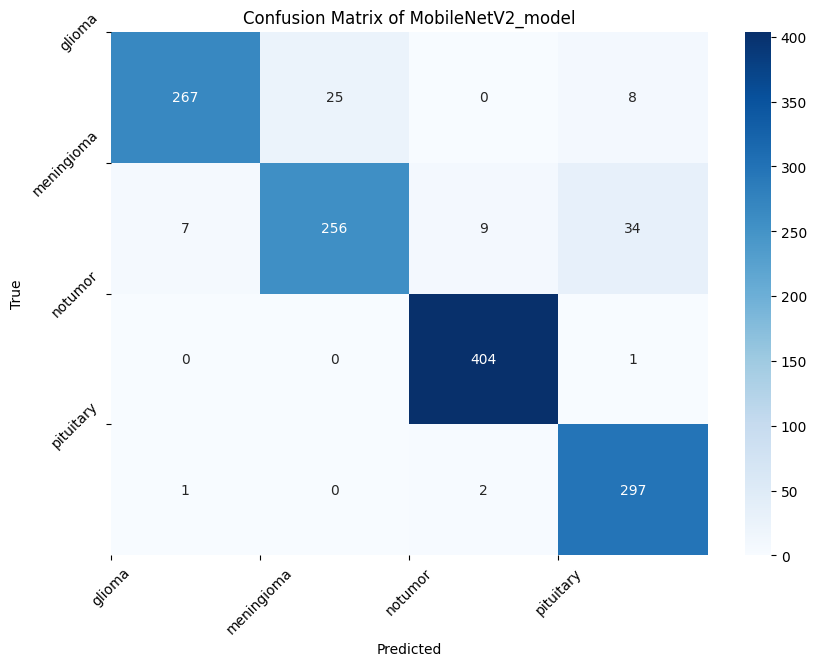

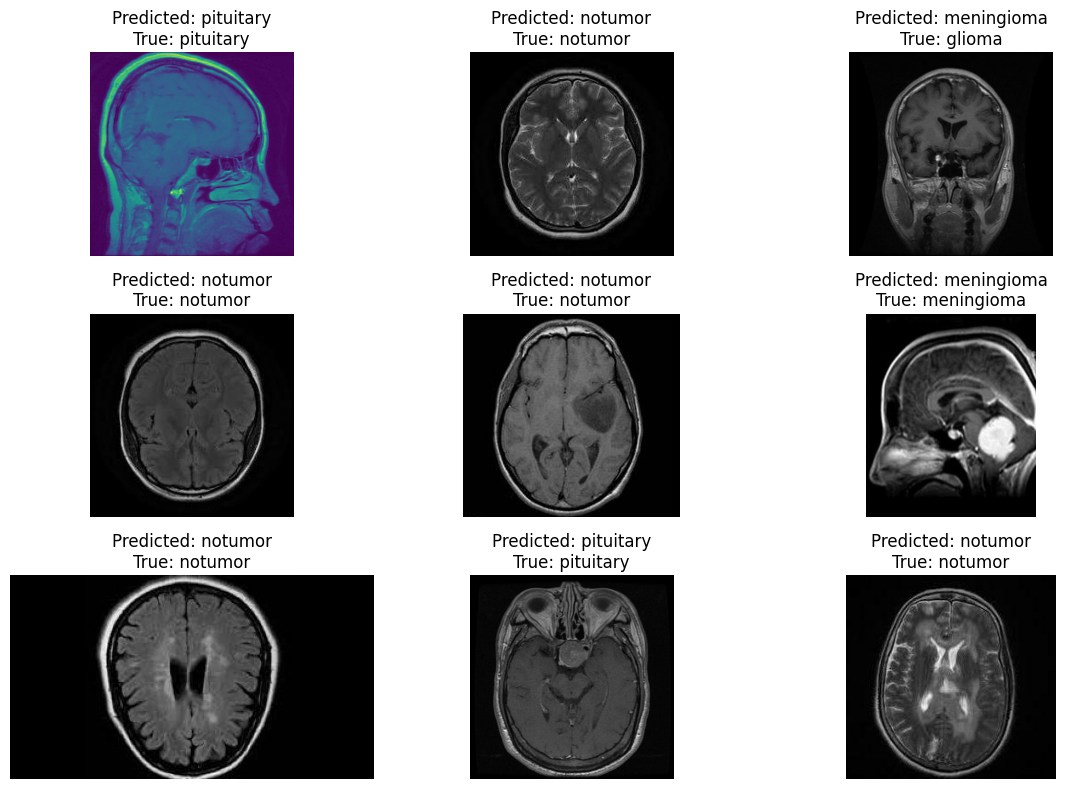

In [26]:
# Make predictions on the test dataset
predictions_MobileNetV2_model = MobileNetV2_model.predict(test_set)
predicted_categories_MobileNetV2_model = np.argmax(predictions_MobileNetV2_model, axis=1)

true_categories_MobileNetV2_model = test_set.classes
print(true_categories_MobileNetV2_model)

# Create a confusion matrix
confusion_matrix_MobileNetV2_model = tf.math.confusion_matrix(true_categories_MobileNetV2_model, predicted_categories_MobileNetV2_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_MobileNetV2_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of MobileNetV2_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_MobileNetV2_model = [categories[predicted_categories_MobileNetV2_model[i]] for i in sample_indices]
sample_true_labels_MobileNetV2_model = [categories[true_categories_MobileNetV2_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_MobileNetV2_model[i]}\nTrue: {sample_true_labels_MobileNetV2_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9709090909090909
Recall: 0.89
F1-Score: 0.9286956521739131

Class: meningioma
Precision: 0.9110320284697508
Recall: 0.8366013071895425
F1-Score: 0.8722316865417377

Class: notumor
Precision: 0.9734939759036144
Recall: 0.9975308641975309
F1-Score: 0.9853658536585366

Class: pituitary
Precision: 0.8735294117647059
Recall: 0.99
F1-Score: 0.928125



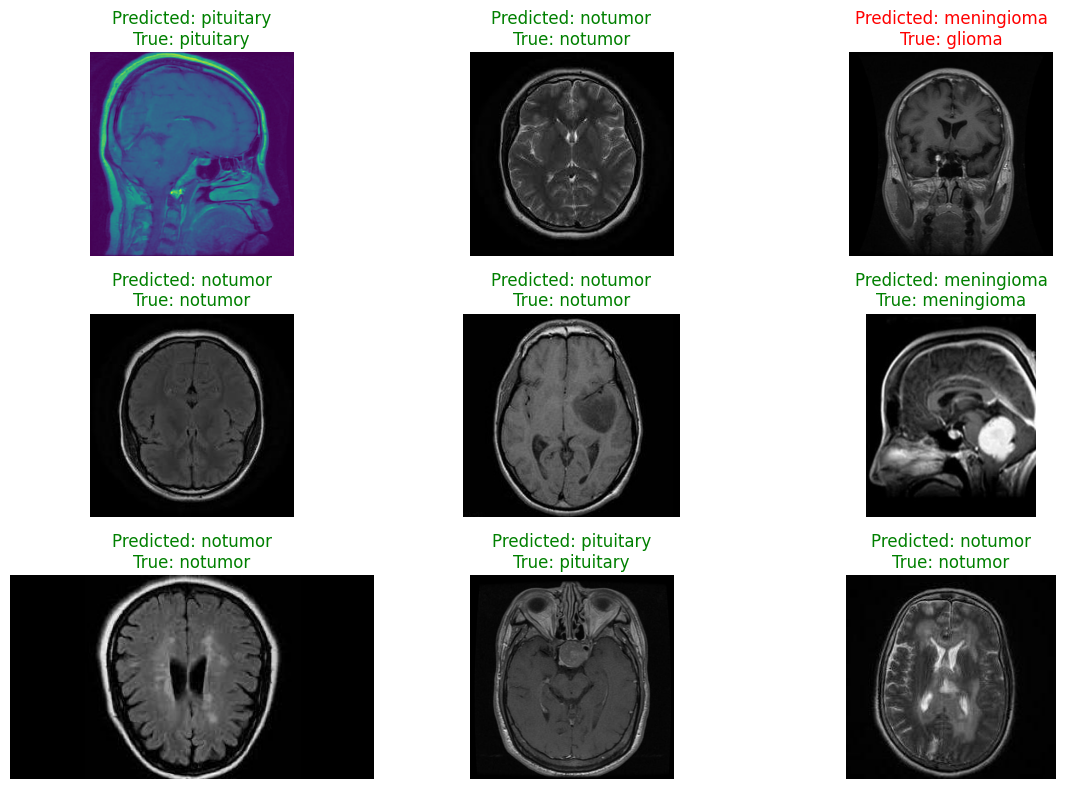

In [27]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_MobileNetV2_model = np.diag(confusion_matrix_MobileNetV2_model) / np.sum(confusion_matrix_MobileNetV2_model, axis=0)
recall_MobileNetV2_model = np.diag(confusion_matrix_MobileNetV2_model) / np.sum(confusion_matrix_MobileNetV2_model, axis=1)
f1_score_MobileNetV2_model = 2 * (precision_MobileNetV2_model * recall_MobileNetV2_model) / (precision_MobileNetV2_model + recall_MobileNetV2_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_MobileNetV2_model[i]}")
    print(f"Recall: {recall_MobileNetV2_model[i]}")
    print(f"F1-Score: {f1_score_MobileNetV2_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_MobileNetV2_model[i] == sample_true_labels_MobileNetV2_model[i]:
        plt.title(f"Predicted: {sample_predictions_MobileNetV2_model[i]}\nTrue: {sample_true_labels_MobileNetV2_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_MobileNetV2_model[i]}\nTrue: {sample_true_labels_MobileNetV2_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


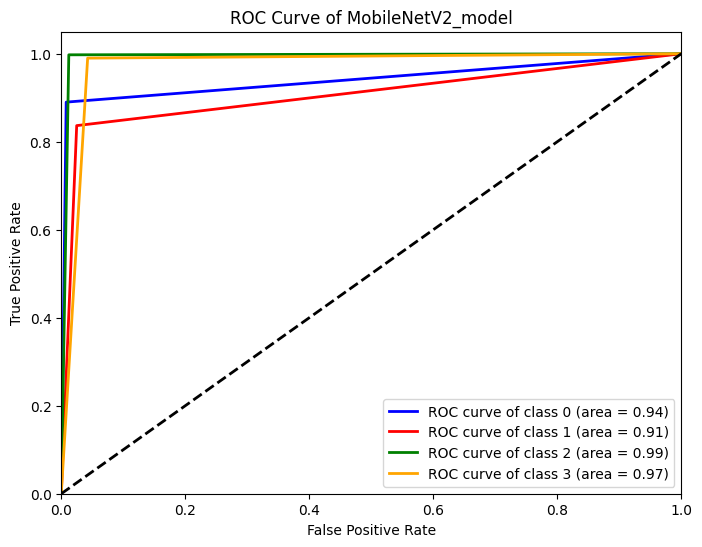

In [28]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_MobileNetV2_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_MobileNetV2_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

class_names = ["glioma", "meningioma", "notumor", "pituitary"]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of MobileNetV2_model')
plt.legend(loc="lower right")

plt.show()


In [29]:
# Save the trained model
MobileNetV2_model.save("MobileNetV2_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# history = model.fit_generator(
history_InceptionV3_model = InceptionV3_model.fit(
    train_set,
    validation_data=test_set,
    epochs=epochs,
    steps_per_epoch=train_set.samples // batch_size,
    validation_steps=test_set.samples // batch_size,
#     callbacks=callbacks,
#     verbose=2
)
# duration = datetime.now() - start
# print("Training completed in time: ", duration)

Epoch 1/50


I0000 00:00:1709615636.031194     144 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 [==============================] - 105s 515ms/step - loss: 0.5178 - accuracy: 0.8079 - val_loss: 0.4788 - val_accuracy: 0.8133
Epoch 2/50
178/178 [==============================] - 69s 390ms/step - loss: 0.3749 - accuracy: 0.8602 - val_loss: 0.4159 - val_accuracy: 0.8391
Epoch 3/50
178/178 [==============================] - 69s 387ms/step - loss: 0.3288 - accuracy: 0.8771 - val_loss: 0.4366 - val_accuracy: 0.8266
Epoch 4/50
178/178 [==============================] - 70s 394ms/step - loss: 0.3118 - accuracy: 0.8864 - val_loss: 0.3643 - val_accuracy: 0.8555
Epoch 5/50
178/178 [==============================] - 69s 387ms/step - loss: 0.2873 - accuracy: 0.8963 - val_loss: 0.4140 - val_accuracy: 0.8406
Epoch 6/50
178/178 [==============================] - 70s 390ms/step - loss: 0.2663 - accuracy: 0.9051 - val_loss: 0.2284 - val_accuracy: 0.9062
Epoch 7/50
178/178 [==============================] - 70s 395ms/step - loss: 0.2575 - accuracy: 0.9049 - val_loss: 0.2626 - val_accuracy: 0.

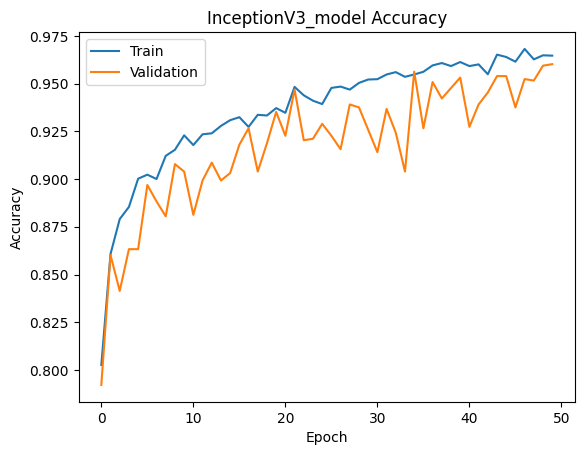

In [31]:
# Plot the training and validation accuracy over epochs
plt.plot(history_InceptionV3_model.history['accuracy'])
plt.plot(history_InceptionV3_model.history['val_accuracy'])
plt.title('InceptionV3_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

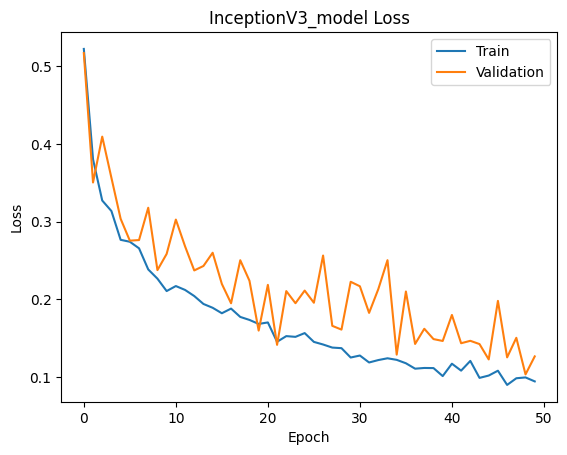

In [32]:
# Plot the training and validation loss over epochs
plt.plot(history_InceptionV3_model.history['loss'])
plt.plot(history_InceptionV3_model.history['val_loss'])
plt.title('InceptionV3_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [33]:
# Evaluate the model
loss_InceptionV3_model, accuracy_InceptionV3_model = InceptionV3_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("InceptionV3_model Test Loss:", loss_InceptionV3_model)
print("InceptionV3_model Test Accuracy:", accuracy_InceptionV3_model)

40/40 [==============================] - 4s 85ms/step - loss: 0.1268 - accuracy: 0.9602
InceptionV3_model Test Loss: 0.12677206099033356
InceptionV3_model Test Accuracy: 0.960156261920929


41/41 [==============================] - 9s 189ms/step
[0 0 0 ... 3 3 3]


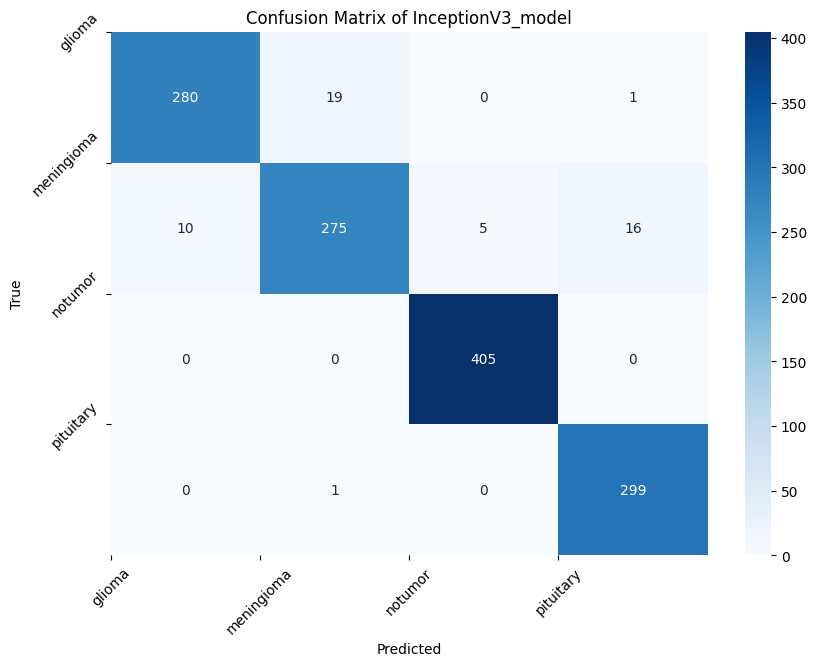

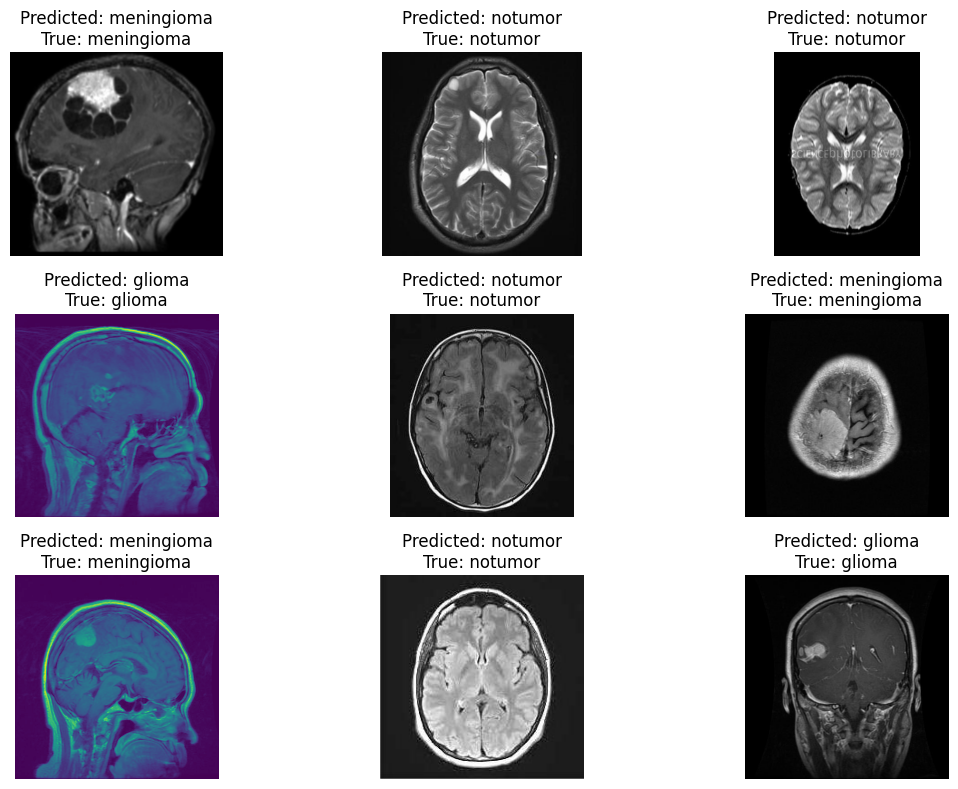

In [34]:
# Make predictions on the test dataset
predictions_InceptionV3_model = InceptionV3_model.predict(test_set)
predicted_categories_InceptionV3_model = np.argmax(predictions_InceptionV3_model, axis=1)

true_categories_InceptionV3_model = test_set.classes
print(true_categories_InceptionV3_model)

# Create a confusion matrix
confusion_matrix_InceptionV3_model = tf.math.confusion_matrix(true_categories_InceptionV3_model, predicted_categories_InceptionV3_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_InceptionV3_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of InceptionV3_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_InceptionV3_model = [categories[predicted_categories_InceptionV3_model[i]] for i in sample_indices]
sample_true_labels_InceptionV3_model = [categories[true_categories_InceptionV3_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9655172413793104
Recall: 0.9333333333333333
F1-Score: 0.9491525423728815

Class: meningioma
Precision: 0.9322033898305084
Recall: 0.8986928104575164
F1-Score: 0.9151414309484192

Class: notumor
Precision: 0.9878048780487805
Recall: 1.0
F1-Score: 0.9938650306748467

Class: pituitary
Precision: 0.9462025316455697
Recall: 0.9966666666666667
F1-Score: 0.9707792207792209



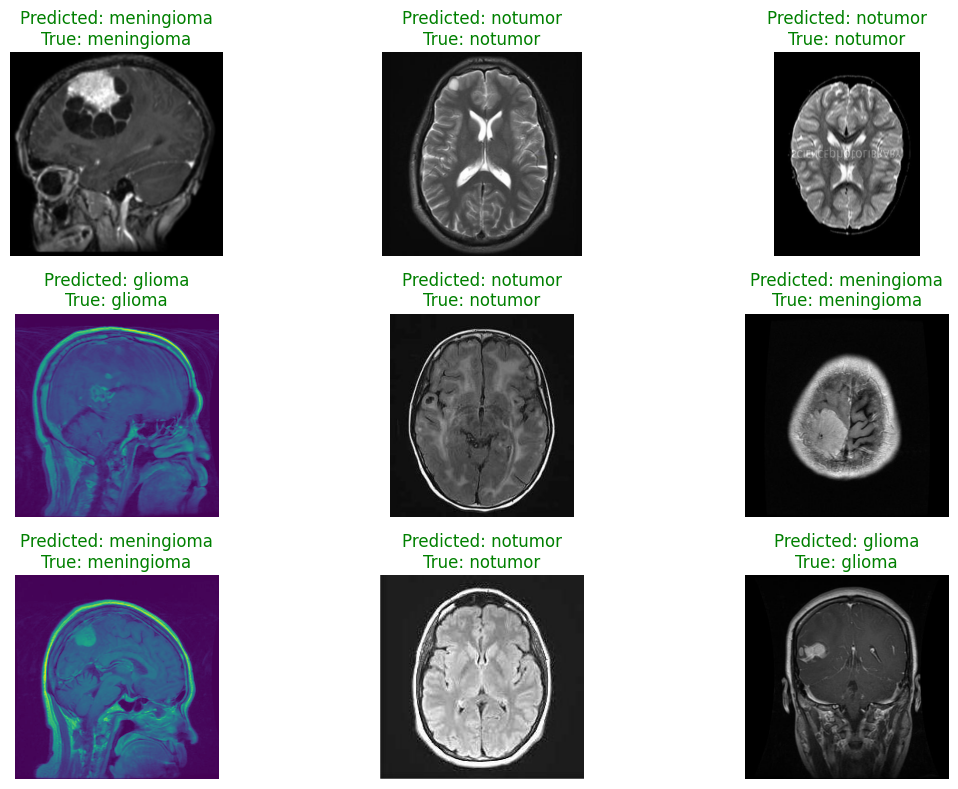

In [35]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_InceptionV3_model = np.diag(confusion_matrix_InceptionV3_model) / np.sum(confusion_matrix_InceptionV3_model, axis=0)
recall_InceptionV3_model = np.diag(confusion_matrix_InceptionV3_model) / np.sum(confusion_matrix_InceptionV3_model, axis=1)
f1_score_InceptionV3_model = 2 * (precision_InceptionV3_model * recall_InceptionV3_model) / (precision_InceptionV3_model + recall_InceptionV3_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_InceptionV3_model[i]}")
    print(f"Recall: {recall_InceptionV3_model[i]}")
    print(f"F1-Score: {f1_score_InceptionV3_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_InceptionV3_model[i] == sample_true_labels_InceptionV3_model[i]:
        plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_InceptionV3_model[i]}\nTrue: {sample_true_labels_InceptionV3_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


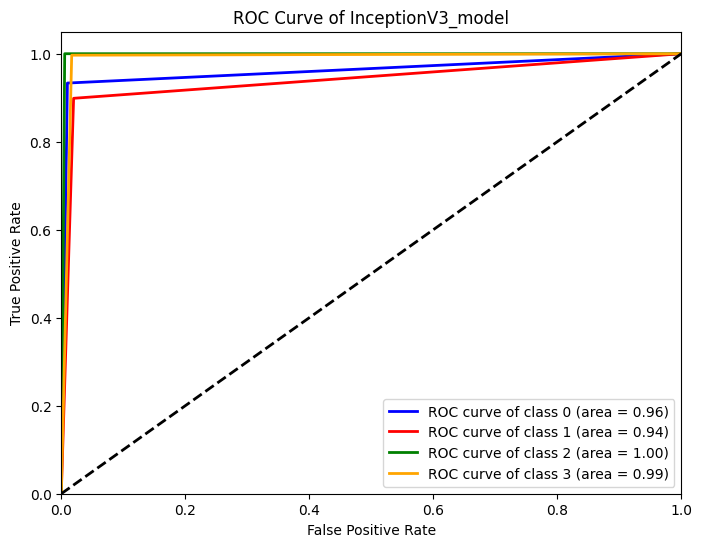

In [36]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_InceptionV3_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_InceptionV3_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

class_names = ["glioma", "meningioma", "notumor", "pituitary"]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of InceptionV3_model')
plt.legend(loc="lower right")

plt.show()


In [37]:
# Save the trained model
InceptionV3_model.save("InceptionV3_model_brain_tumor_detection_model.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
DenseNet201 = keras.applications.DenseNet201(input_shape=(224, 224, 3),
            weights='imagenet',
            include_top=False)

74836368/74836368 [==============================] - 1s 0us/step


In [39]:
for layer in DenseNet201.layers:
    layer.trainable = False

In [40]:
folders = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
print(len(folders))

4


In [41]:
x = DenseNet201.output

x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
x = Conv2D(256, 5, strides=2, padding='same', activation='relu')(x)
x = Conv2D(512, 7, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)

# x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(len(folders), activation='softmax')(x)
DenseNet201_model = Model(inputs=DenseNet201.input, outputs=prediction)

In [42]:
DenseNet201_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [43]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
DenseNet201_model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train the model
history_DenseNet201_model = DenseNet201_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size
)

Epoch 1/50
178/178 [==============================] - 101s 455ms/step - loss: 0.4863 - accuracy: 0.8153 - val_loss: 0.6457 - val_accuracy: 0.8414
Epoch 2/50
178/178 [==============================] - 73s 411ms/step - loss: 0.3065 - accuracy: 0.8901 - val_loss: 0.3878 - val_accuracy: 0.8562
Epoch 3/50
178/178 [==============================] - 73s 409ms/step - loss: 0.2546 - accuracy: 0.9062 - val_loss: 0.3922 - val_accuracy: 0.8531
Epoch 4/50
178/178 [==============================] - 73s 411ms/step - loss: 0.2206 - accuracy: 0.9187 - val_loss: 0.5767 - val_accuracy: 0.8141
Epoch 5/50
178/178 [==============================] - 73s 411ms/step - loss: 0.2183 - accuracy: 0.9202 - val_loss: 0.3530 - val_accuracy: 0.8789
Epoch 6/50
178/178 [==============================] - 73s 410ms/step - loss: 0.1777 - accuracy: 0.9345 - val_loss: 0.4096 - val_accuracy: 0.8727
Epoch 7/50
178/178 [==============================] - 73s 410ms/step - loss: 0.1771 - accuracy: 0.9356 - val_loss: 0.2760 - val_a

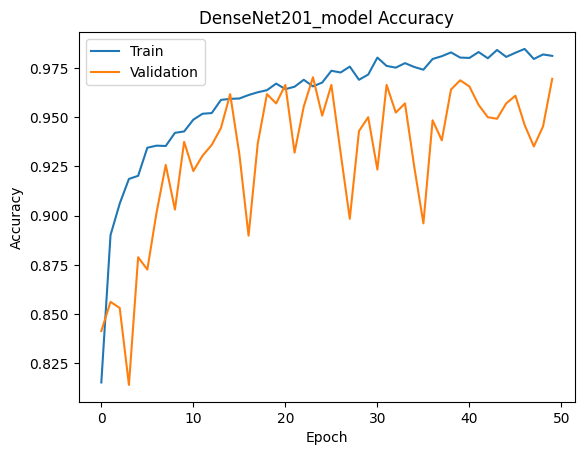

In [45]:
# Plot the training and validation accuracy over epochs
plt.plot(history_DenseNet201_model.history['accuracy'])
plt.plot(history_DenseNet201_model.history['val_accuracy'])
plt.title('DenseNet201_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

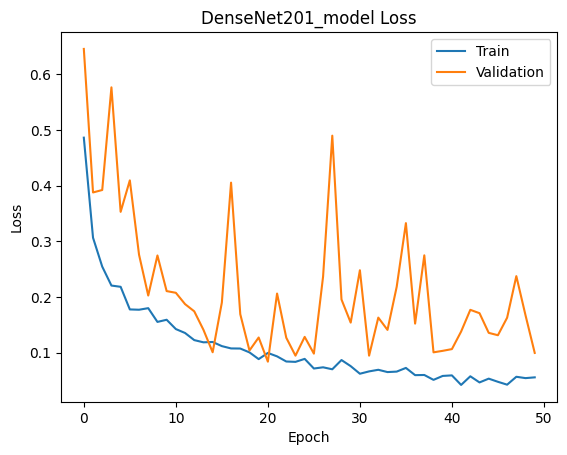

In [46]:
# Plot the training and validation loss over epochs
plt.plot(history_DenseNet201_model.history['loss'])
plt.plot(history_DenseNet201_model.history['val_loss'])
plt.title('DenseNet201_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [47]:
# Evaluate the model
loss_DenseNet201_model, accuracy_DenseNet201_model = DenseNet201_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("DenseNet201_model Test Loss:", loss_DenseNet201_model)
print("DenseNet201_model Test Accuracy:", accuracy_DenseNet201_model)

40/40 [==============================] - 6s 153ms/step - loss: 0.0995 - accuracy: 0.9695
DenseNet201_model Test Loss: 0.0995442196726799
DenseNet201_model Test Accuracy: 0.969531238079071


41/41 [==============================] - 17s 344ms/step
[0 0 0 ... 3 3 3]


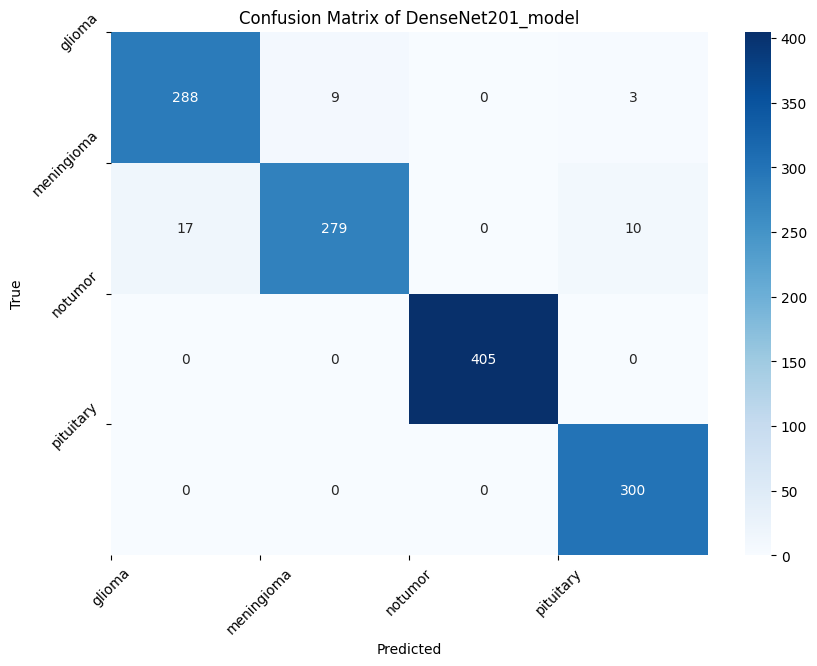

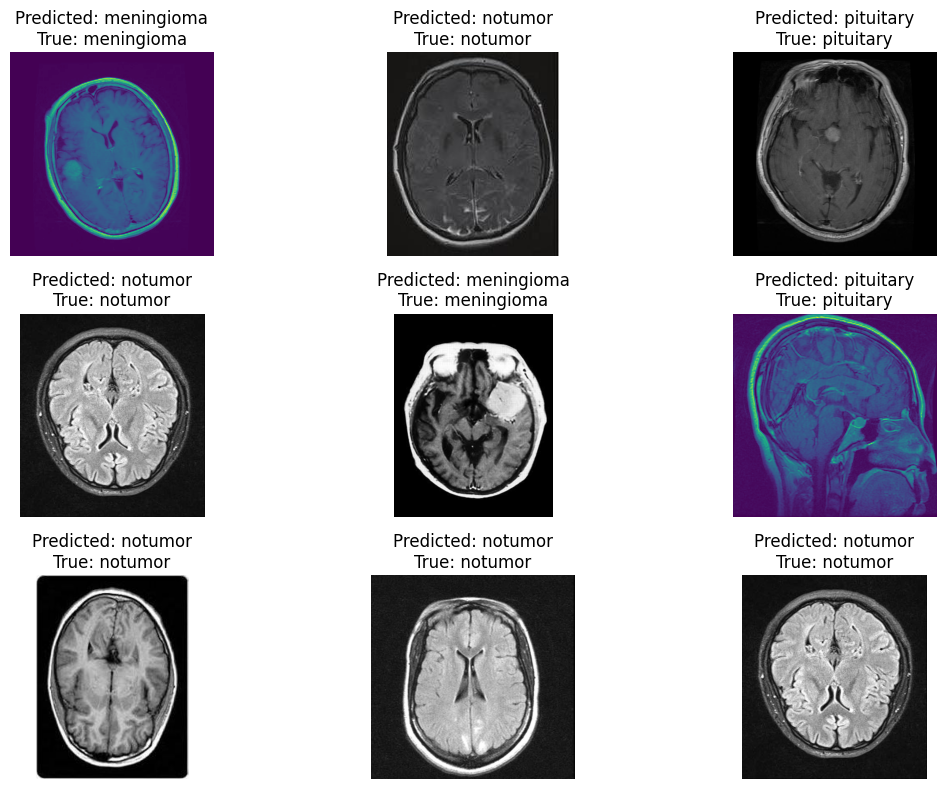

In [48]:
# Make predictions on the test dataset
predictions_DenseNet201_model = DenseNet201_model.predict(test_set)
predicted_categories_DenseNet201_model = np.argmax(predictions_DenseNet201_model, axis=1)

true_categories_DenseNet201_model = test_set.classes
print(true_categories_DenseNet201_model)

# Create a confusion matrix
confusion_matrix_DenseNet201_model = tf.math.confusion_matrix(true_categories_DenseNet201_model, predicted_categories_DenseNet201_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_DenseNet201_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of DenseNet201_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_DenseNet201_model = [categories[predicted_categories_DenseNet201_model[i]] for i in sample_indices]
sample_true_labels_DenseNet201_model = [categories[true_categories_DenseNet201_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_DenseNet201_model[i]}\nTrue: {sample_true_labels_DenseNet201_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9442622950819672
Recall: 0.96
F1-Score: 0.9520661157024793

Class: meningioma
Precision: 0.96875
Recall: 0.9117647058823529
F1-Score: 0.9393939393939394

Class: notumor
Precision: 1.0
Recall: 1.0
F1-Score: 1.0

Class: pituitary
Precision: 0.9584664536741214
Recall: 1.0
F1-Score: 0.9787928221859706



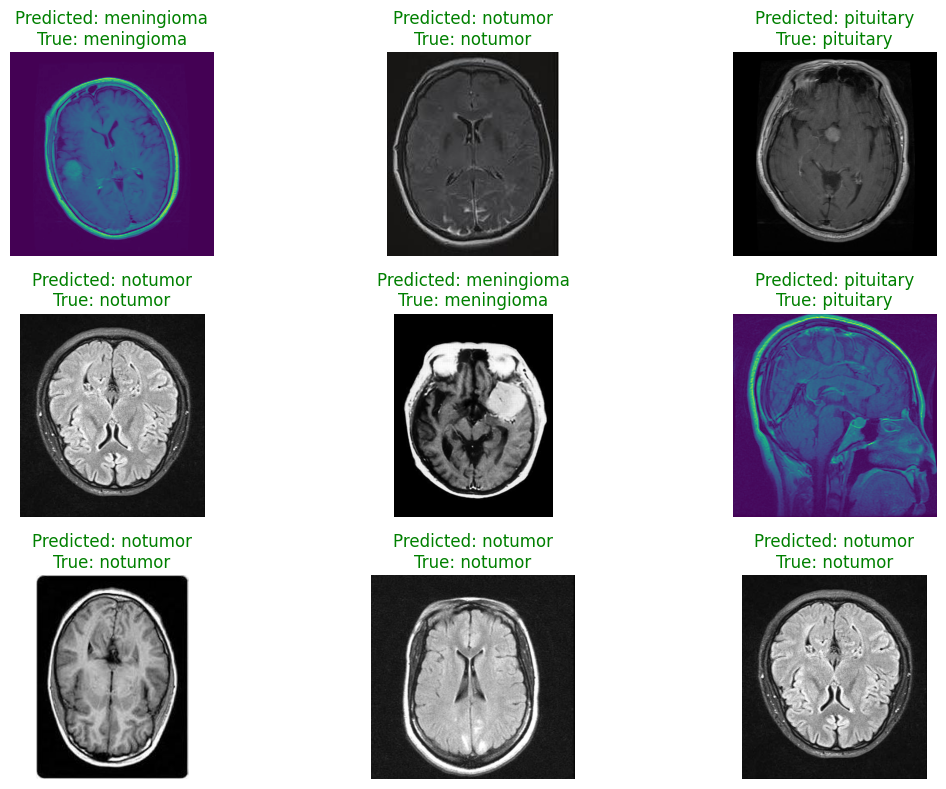

In [49]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_DenseNet201_model = np.diag(confusion_matrix_DenseNet201_model) / np.sum(confusion_matrix_DenseNet201_model, axis=0)
recall_DenseNet201_model = np.diag(confusion_matrix_DenseNet201_model) / np.sum(confusion_matrix_DenseNet201_model, axis=1)
f1_score_DenseNet201_model = 2 * (precision_DenseNet201_model * recall_DenseNet201_model) / (precision_DenseNet201_model + recall_DenseNet201_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_DenseNet201_model[i]}")
    print(f"Recall: {recall_DenseNet201_model[i]}")
    print(f"F1-Score: {f1_score_DenseNet201_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_DenseNet201_model[i] == sample_true_labels_DenseNet201_model[i]:
        plt.title(f"Predicted: {sample_predictions_DenseNet201_model[i]}\nTrue: {sample_true_labels_DenseNet201_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_DenseNet201_model[i]}\nTrue: {sample_true_labels_DenseNet201_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


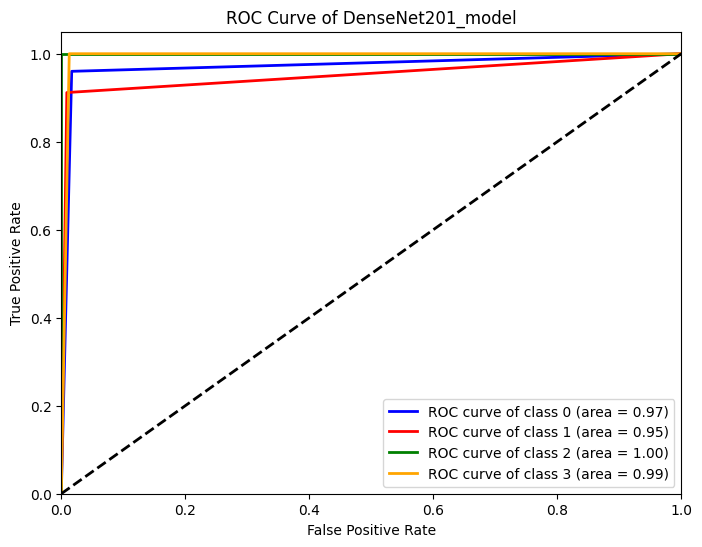

In [50]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_DenseNet201_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_DenseNet201_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

class_names = ["glioma", "meningioma", "notumor", "pituitary"]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of DenseNet201_model')
plt.legend(loc="lower right")

plt.show()

In [56]:
# Save the trained model
DenseNet201_model.save("DenseNet201_model_brain_tumor_detection_model.h5")

In [10]:
from tensorflow.keras.models import load_model

MobileNetV2_model = load_model('/kaggle/working/MobileNetV2_model_brain_tumor_detection_model.h5')
MobileNetV2_model = Model(inputs=MobileNetV2_model.inputs,
                       outputs=MobileNetV2_model.outputs,
                       name='MobileNetV2_model')

InceptionV3_model = load_model('/kaggle/working/InceptionV3_model_brain_tumor_detection_model.h5')
InceptionV3_model = Model(inputs=InceptionV3_model.inputs,
                       outputs=InceptionV3_model.outputs,
                       name='InceptionV3_model')

DenseNet201_model = load_model('/kaggle/working/DenseNet201_model_brain_tumor_detection_model.h5')
DenseNet201_model = Model(inputs=DenseNet201_model.inputs,
                       outputs=DenseNet201_model.outputs,
                       name='DenseNet201_model')

OSError: No file or directory found at /kaggle/working/InceptionV3_model_brain_tumor_detection_model.h5

In [118]:
models = [MobileNetV2_model, InceptionV3_model, DenseNet201_model]
model_input = Input(shape = (224, 224, 3))
model_outputs = [model(model_input) for model in models]

class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **Kwargs):
        super(WeightedAverageLayer, self).__init__(**Kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        
    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2] 


Ensamble_output = WeightedAverageLayer(0.1, 0.3, 0.6)(model_outputs)

Ensamble_model = Model(inputs=model_input, outputs=Ensamble_output, name='Ensamble_model')

In [119]:
adam = keras.optimizers.Adam(learning_rate=0.0001) 
# Ensamble_model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
Ensamble_model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history_Ensamble_model = Ensamble_model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size
)

Epoch 1/50


In [ ]:
# Plot the training and validation accuracy over epochs
plt.plot(history_Ensamble_model.history['accuracy'])
plt.plot(history_Ensamble_model.history['val_accuracy'])
plt.title('Ensamble_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# axes = plt.axes()
# axes.set_ylim([0.9, 1])
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Plot the training and validation loss over epochs
plt.plot(history_Ensamble_model.history['loss'])
plt.plot(history_Ensamble_model.history['val_loss'])
plt.title('Ensamble_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Evaluate the model
loss_Ensamble_model, accuracy_Ensamble_model = Ensamble_model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("Ensamble_model Test Loss:", loss_Ensamble_model)
print("Ensamble_model Test Accuracy:", accuracy_Ensamble_model)

In [ ]:
# Make predictions on the test dataset
predictions_Ensamble_model = Ensamble_model.predict(test_set)
predicted_categories_Ensamble_model = np.argmax(predictions_Ensamble_model, axis=1)

true_categories_Ensamble_model = test_set.classes
print(true_categories_Ensamble_model)

# Create a confusion matrix
confusion_matrix_Ensamble_model = tf.math.confusion_matrix(true_categories_Ensamble_model, predicted_categories_Ensamble_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_Ensamble_model, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Ensamble_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
# print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions_Ensamble_model = [categories[predicted_categories_Ensamble_model[i]] for i in sample_indices]
sample_true_labels_Ensamble_model = [categories[true_categories_Ensamble_model[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision_Ensamble_model = np.diag(confusion_matrix_Ensamble_model) / np.sum(confusion_matrix_Ensamble_model, axis=0)
recall_Ensamble_model = np.diag(confusion_matrix_Ensamble_model) / np.sum(confusion_matrix_Ensamble_model, axis=1)
f1_score_Ensamble_model = 2 * (precision_Ensamble_model * recall_Ensamble_model) / (precision_Ensamble_model + recall_Ensamble_model)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision_Ensamble_model[i]}")
    print(f"Recall: {recall_Ensamble_model[i]}")
    print(f"F1-Score: {f1_score_Ensamble_model[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions_Ensamble_model[i] == sample_true_labels_Ensamble_model[i]:
        plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions_Ensamble_model[i]}\nTrue: {sample_true_labels_Ensamble_model[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories_Ensamble_model, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories_Ensamble_model, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Ensamble_model')
plt.legend(loc="lower right")

plt.show()

In [ ]:
# Save the trained model
Ensamble_model.save("EL_model_brain_tumor_detection_model.h5")